In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

In [13]:
def return_sf(dur, cens, bins):
    km = KaplanMeierFitter()
    km.fit(dur, cens)
    return km.survival_function_at_times(bins).to_numpy()

def return_sf_2(dur, cens, bins):
    inner_bins = np.unique(dur)
    dur_ = np.searchsorted(inner_bins, dur)
    hist_dur = np.bincount(dur_)
    hist_cens = np.bincount(dur_, weights=cens)
    cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
    sf = np.hstack([1.0, np.cumprod((1.0 - hist_cens / (cumul_hist)))])
    
    place_bin = np.digitize(bins, inner_bins)
    return sf[np.clip(place_bin, 0, None)]

dur = np.random.uniform(0, 10000, 10000)
cens = np.random.choice(2, 10000)
bins = np.sort(np.random.uniform(0, 10000, 100))

wei = np.random.choice(20, 10000)

In [3]:
%timeit return_sf(dur, cens, bins)

13.4 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%timeit return_sf_2(dur, cens, bins)

1.33 ms ± 4.64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


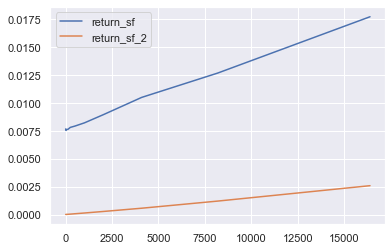

In [5]:
import timeit
def plot_km_performance_scaling_test(functions, size_samples):
    times = {func.__name__ : [] for func in functions}
    res = {func.__name__ : [] for func in functions}
    for i in size_samples:
        dur = np.random.uniform(0, 10000, i)
        cens = np.random.choice(2, i)
        bins = np.sort(np.random.uniform(0, 10000, i))
        
        for func in functions:
            sf_ = func(dur, cens, bins)
            
            res[func.__name__].append(sf_)
            times[func.__name__].append(timeit.timeit(lambda: func(dur, cens, bins), number=100)/100)
    
    fig = plt.figure()
    for func in functions:
        plt.plot(size_samples, times[func.__name__], label = func.__name__)
    plt.legend()
    plt.show()
    return times, res

times_km, res_km = plot_km_performance_scaling_test([return_sf, 
                                                     return_sf_2], 
                                                    [2**i for i in range(3, 15)])

In [6]:
for i, j in zip(res_km["return_sf"], res_km["return_sf_2"]):
    print("life", i)
    print("self", j)

life [1.         0.85714286 0.85714286 0.85714286 0.85714286 0.85714286
 0.57142857 0.        ]
self [1.         0.85714286 0.85714286 0.85714286 0.85714286 0.85714286
 0.57142857 0.        ]
life [1.         1.         1.         0.93333333 0.86666667 0.64
 0.42666667 0.42666667 0.42666667 0.42666667 0.28444444 0.14222222
 0.14222222 0.14222222 0.         0.        ]
self [1.         1.         1.         0.93333333 0.86666667 0.64
 0.42666667 0.42666667 0.42666667 0.42666667 0.28444444 0.14222222
 0.14222222 0.14222222 0.         0.        ]
life [1.         1.         1.         1.         1.         1.
 0.96153846 0.96153846 0.8361204  0.8361204  0.8361204  0.8361204
 0.8361204  0.74810773 0.70410139 0.70410139 0.70410139 0.61022121
 0.61022121 0.61022121 0.61022121 0.61022121 0.61022121 0.61022121
 0.61022121 0.43686291 0.37445392 0.37445392 0.37445392 0.37445392
 0.37445392 0.37445392]
self [1.         1.         1.         1.         1.         1.
 0.96153846 0.96153846 0.836120

In [7]:
return_sf(np.array([1, 10, 75, 100, 150]),
          np.array([1, 1, 1, 1, 1]),
          np.array([0.1, 5, 50]),
         )
# array([1. , 0.8, 0.6])
return_sf_2(np.array([1, 10, 75, 100, 150]),
          np.array([1, 1, 1, 1, 1]),
          np.array([0.1, 5, 50]),
         )
# array([0.8, 0.8, 0.6])

array([1. , 0.8, 0.6])

In [44]:
km_w = KaplanMeierFitter()
km_w.fit(dur, cens, weights = wei)
km_w.survival_function_at_times(bins).to_numpy()

array([0.99750225, 0.98729212, 0.98586686, 0.98506063, 0.98480857,
       0.97730619, 0.9766748 , 0.96651619, 0.96510875, 0.94601546,
       0.94019387, 0.93639066, 0.93200667, 0.93021555, 0.92959117,
       0.92774716, 0.91844704, 0.91746646, 0.91201298, 0.90829914,
       0.89464874, 0.89376393, 0.8895278 , 0.88706885, 0.88261588,
       0.88259412, 0.8812608 , 0.8785551 , 0.87447784, 0.8731305 ,
       0.8602645 , 0.85934969, 0.84829137, 0.83657472, 0.82084231,
       0.82057649, 0.81865023, 0.81228511, 0.80021275, 0.79519585,
       0.79519585, 0.79006413, 0.79004501, 0.78825177, 0.78667136,
       0.78612111, 0.78344725, 0.78068179, 0.77742579, 0.77533984,
       0.76171557, 0.75000514, 0.73742734, 0.72778283, 0.71759778,
       0.7105869 , 0.69707   , 0.69396151, 0.69288894, 0.66668747,
       0.66282467, 0.65335469, 0.64006394, 0.63864259, 0.6164629 ,
       0.6118418 , 0.61047254, 0.60872986, 0.59764229, 0.59545585,
       0.58245873, 0.57179486, 0.56364161, 0.55104819, 0.54625

In [16]:
km = KaplanMeierFitter()
km.fit(dur, cens)
km.survival_function_at_times(bins).to_numpy()

array([0.9977988 , 0.98681655, 0.98529484, 0.98468517, 0.98427838,
       0.97661568, 0.97589693, 0.96607909, 0.96431237, 0.94493563,
       0.93937985, 0.93562438, 0.93174019, 0.92957388, 0.92903179,
       0.92762097, 0.91822555, 0.91712493, 0.91170809, 0.90848758,
       0.89528581, 0.89427111, 0.8900863 , 0.88747394, 0.88290713,
       0.88279255, 0.8814162 , 0.87865733, 0.87461356, 0.8727594 ,
       0.85978123, 0.85883895, 0.84768506, 0.83532723, 0.82059656,
       0.82010651, 0.81863479, 0.81197238, 0.79924126, 0.79457625,
       0.79457625, 0.78898896, 0.78886152, 0.786818  , 0.78515061,
       0.7841209 , 0.78128321, 0.77882532, 0.77545096, 0.77389037,
       0.75877278, 0.74494918, 0.73276536, 0.72304469, 0.71218723,
       0.70561158, 0.69172083, 0.68863976, 0.68746291, 0.6614645 ,
       0.6573102 , 0.64878756, 0.6355849 , 0.63415678, 0.61178045,
       0.60663653, 0.6053039 , 0.60363442, 0.59283755, 0.59027152,
       0.57844965, 0.56832579, 0.56129276, 0.5482885 , 0.54232

In [18]:
wei = np.random.choice(200, 10000)

In [21]:
def return_sf_2(dur, cens, bins, weights):
    inner_bins = np.unique(dur)
    dur_ = np.searchsorted(inner_bins, dur)
    hist_dur = np.bincount(dur_, weights=weights)
    hist_cens = np.bincount(dur_, weights=cens*weights)
    cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
    sf = np.hstack([1.0, np.cumprod((1.0 - hist_cens / (cumul_hist)))])
    
    place_bin = np.digitize(bins, inner_bins)
    return sf[np.clip(place_bin, 0, None)]

In [36]:
return_sf_2(dur, cens, bins, wei*1000)

array([0.99750225, 0.98729212, 0.98586686, 0.98506063, 0.98480857,
       0.97730619, 0.9766748 , 0.96651619, 0.96510875, 0.94601546,
       0.94019387, 0.93639066, 0.93200667, 0.93021555, 0.92959117,
       0.92774716, 0.91844704, 0.91746646, 0.91201298, 0.90829914,
       0.89464874, 0.89376393, 0.8895278 , 0.88706885, 0.88261588,
       0.88259412, 0.8812608 , 0.8785551 , 0.87447784, 0.8731305 ,
       0.8602645 , 0.85934969, 0.84829137, 0.83657472, 0.82084231,
       0.82057649, 0.81865023, 0.81228511, 0.80021275, 0.79519585,
       0.79519585, 0.79006413, 0.79004501, 0.78825177, 0.78667136,
       0.78612111, 0.78344725, 0.78068179, 0.77742579, 0.77533984,
       0.76171557, 0.75000514, 0.73742734, 0.72778283, 0.71759778,
       0.7105869 , 0.69707   , 0.69396151, 0.69288894, 0.66668747,
       0.66282467, 0.65335469, 0.64006394, 0.63864259, 0.6164629 ,
       0.6118418 , 0.61047254, 0.60872986, 0.59764229, 0.59545585,
       0.58245873, 0.57179486, 0.56364161, 0.55104819, 0.54625

### NA

In [32]:
km = NelsonAalenFitter()
km.fit(dur, cens)
km.cumulative_hazard_at_times(bins).to_numpy()

array([2.20351786e-03, 1.32704546e-02, 1.48136024e-02, 1.54325314e-02,
       1.58457119e-02, 2.36608628e-02, 2.43970519e-02, 3.45077851e-02,
       3.63381185e-02, 5.66354659e-02, 6.25320108e-02, 6.65376171e-02,
       7.06974575e-02, 7.30250442e-02, 7.36083387e-02, 7.51280012e-02,
       8.53075488e-02, 8.65068352e-02, 9.24303112e-02, 9.59687432e-02,
       1.10606040e-01, 1.11740002e-01, 1.16430258e-01, 1.19369340e-01,
       1.24528148e-01, 1.24657917e-01, 1.26218116e-01, 1.29352871e-01,
       1.33965401e-01, 1.36087490e-01, 1.51068425e-01, 1.52164898e-01,
       1.65236238e-01, 1.79920819e-01, 1.97711460e-01, 1.98308787e-01,
       2.00104815e-01, 2.08275931e-01, 2.24078176e-01, 2.29931617e-01,
       2.29931617e-01, 2.36987680e-01, 2.37149204e-01, 2.39742823e-01,
       2.41864049e-01, 2.43176280e-01, 2.46801486e-01, 2.49952159e-01,
       2.54293832e-01, 2.56308186e-01, 2.76034354e-01, 2.94419070e-01,
       3.10908009e-01, 3.24261235e-01, 3.39389943e-01, 3.48664932e-01,
      

In [33]:
def return_hf_2(dur, cens, bins):
    inner_bins = np.unique(dur)
    dur_ = np.searchsorted(inner_bins, dur)
    hist_dur = np.bincount(dur_)
    hist_cens = np.bincount(dur_, weights=cens)
    cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
    hf = np.hstack([0.0, np.cumsum(hist_cens / cumul_hist)])

    place_bin = np.digitize(bins, inner_bins)
    return hf[place_bin]

return_hf_2(dur, cens, bins)

array([2.20351786e-03, 1.32704546e-02, 1.48136024e-02, 1.54325314e-02,
       1.58457119e-02, 2.36608628e-02, 2.43970519e-02, 3.45077851e-02,
       3.63381185e-02, 5.66354659e-02, 6.25320108e-02, 6.65376171e-02,
       7.06974575e-02, 7.30250442e-02, 7.36083387e-02, 7.51280012e-02,
       8.53075488e-02, 8.65068352e-02, 9.24303112e-02, 9.59687432e-02,
       1.10606040e-01, 1.11740002e-01, 1.16430258e-01, 1.19369340e-01,
       1.24528148e-01, 1.24657917e-01, 1.26218116e-01, 1.29352871e-01,
       1.33965401e-01, 1.36087490e-01, 1.51068425e-01, 1.52164898e-01,
       1.65236238e-01, 1.79920819e-01, 1.97711460e-01, 1.98308787e-01,
       2.00104815e-01, 2.08275931e-01, 2.24078176e-01, 2.29931617e-01,
       2.29931617e-01, 2.36987680e-01, 2.37149204e-01, 2.39742823e-01,
       2.41864049e-01, 2.43176280e-01, 2.46801486e-01, 2.49952159e-01,
       2.54293832e-01, 2.56308186e-01, 2.76034354e-01, 2.94419070e-01,
       3.10908009e-01, 3.24261235e-01, 3.39389943e-01, 3.48664932e-01,
      

### PLOT TEST

In [137]:
import scipy.stats as ss

class KaplanMeier:
    def __init__(self, alpha=0.05, weights=None):
        self.alpha = alpha
        self.weights = weights

    def fit(self, durations, right_censor):
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        hist_dur = np.bincount(dur_)
        hist_cens = np.bincount(dur_, weights=right_censor)
        cumul_hist = np.cumsum(hist_dur[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - hist_cens / (cumul_hist)))])
        
        z = ss.norm.ppf(1 - self.alpha / 2)
        
        cumulative_sq_ = np.append(np.cumsum(hist_cens / (cumul_hist * (cumul_hist - hist_cens))), 0)
              
        v = np.log(self.survival_function)

        print(np.exp(-np.exp(self.survival_function - z * np.sqrt(cumulative_sq_) / v)))
        print(np.exp(-np.exp(self.survival_function + z * np.sqrt(cumulative_sq_) / v)))

    def survival_function_at_times(self, times):
        place_bin = np.digitize(times, self.timeline)
        return self.survival_function[np.clip(place_bin, 0, None)]
    
    def plot_survival_function(self):
        t = np.insert(self.timeline, 0, 0)
        print(t)
        plt.step(t, self.survival_function, label = "survival_fuction", where="post")
        plt.xlabel("timeline")
        plt.legend()
        plt.fill_between(t, self.survival_function+self.confidence_interval, 
        self.survival_function-self.confidence_interval, step="post", alpha = 0.25)       

In [72]:
from lifelines.datasets import load_waltons
waltons = load_waltons()

<AxesSubplot:xlabel='timeline'>

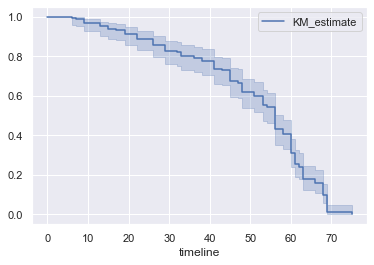

In [86]:
km_w = KaplanMeierFitter(alpha = 0.05)
km_w.fit(waltons['T'], waltons['E'])
km_w.plot_survival_function()

[ 0.  6.  7.  9. 13. 15. 17. 19. 22. 26. 29. 32. 33. 36. 38. 41. 43. 45.
 47. 48. 51. 53. 54. 56. 58. 60. 61. 62. 63. 66. 68. 69. 75.]


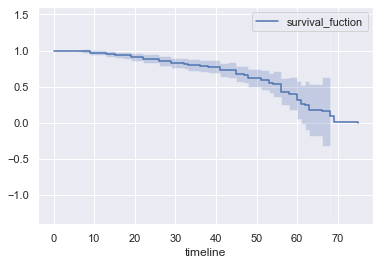

In [138]:
km_w_ = KaplanMeier()
km_w_.fit(waltons['T'], waltons['E'])
km_w_.plot_survival_function()

In [68]:
ss.norm.ppf(1 - 0.05 / 2)

1.959963984540054

In [141]:
print(km_w.confidence_interval_survival_function_)
km_w.survival_function_

      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                 1.000000                1.000000
6.0                 0.957254                0.999134
7.0                 0.951834                0.996917
9.0                 0.927613                0.987068
13.0                0.903821                0.975031
15.0                0.888437                0.966342
17.0                0.880865                0.961853
19.0                0.858549                0.947930
22.0                0.829547                0.928543
26.0                0.794213                0.903336
29.0                0.759669                0.877313
32.0                0.752841                0.872027
33.0                0.732496                0.856023
36.0                0.719044                0.845243
38.0                0.705674                0.834379
41.0                0.659464                0.795770
43.0                0.652931                0.790186
45.0                0.594825                0.

,KM_estimate
timeline,
0.0,1.000000
6.0,0.993865
7.0,0.987730
9.0,0.969210
13.0,0.950690
15.0,0.938344
17.0,0.932170
19.0,0.913650
22.0,0.888957


In [139]:
km_w_.survival_function + km_w_.confidence_interval

array([1.01206137, 1.01097528, 1.01514417, 1.00425553, 0.9901414 ,
       0.97986184, 0.97949303, 0.96806024, 0.95156726, 0.92845558,
       0.89910433, 0.89742683, 0.88187196, 0.87247264, 0.87038368,
       0.82863689, 0.83581192, 0.78178925, 0.78815111, 0.74319927,
       0.73639972, 0.69632897, 0.71990121, 0.61713696, 0.63473388,
       0.57690235, 0.5300622 , 0.575003  , 0.54040643, 0.63541059,
       1.4685106 ,        inf, 0.        ])

In [140]:
km_w_.survival_function - km_w_.confidence_interval

array([ 0.98793863,  0.97675478,  0.96031595,  0.93416471,  0.91123897,
        0.89682528,  0.88484746,  0.85924038,  0.82634685,  0.7877254 ,
        0.75534353,  0.7446744 ,  0.72318939,  0.70789546,  0.68529117,
        0.64061158,  0.62108992,  0.56399296,  0.54517016,  0.49043442,
        0.45985113,  0.41269526,  0.36420112,  0.24266834,  0.17522763,
        0.04614497, -0.02145214, -0.09316189, -0.1790256 , -0.31418318,
       -1.26774347,        -inf,  0.        ])

In [115]:
km_w_.survival_function

array([1.        , 0.99386503, 0.98773006, 0.96921012, 0.95069018,
       0.93834356, 0.93217025, 0.91365031, 0.88895706, 0.85809049,
       0.82722393, 0.82105061, 0.80253067, 0.79018405, 0.77783742,
       0.73462423, 0.72845092, 0.6728911 , 0.66666063, 0.61681685,
       0.59812543, 0.55451211, 0.54205117, 0.42990265, 0.40498076,
       0.31152366, 0.25430503, 0.24092055, 0.18069041, 0.1606137 ,
       0.10038356, 0.01434051, 0.        ])

In [116]:
km_w._additive_var

<bound method KaplanMeierFitter._additive_var of <lifelines.KaplanMeierFitter:"KM_estimate", fitted with 163 total observations, 7 right-censored observations>>